# Pryngles module: optics

Template of a module

## External modules

In [37]:
#@external
from pryngles import *
#@end:external
import pryngles.pixx as pixx
import time
pixx.rdfous_planet.__doc__

"xmu,rfou = rdfous_planet(foufile,nfou,nmat,nmugs)\n\nWrapper for ``rdfous_planet``.\n\nParameters\n----------\nfoufile : input string(len=100)\nnfou : input int\nnmat : input int\nnmugs : input int\n\nReturns\n-------\nxmu : rank-1 array('d') with bounds (nmugs)\nrfou : rank-3 array('d') with bounds (nmat*nmugs,nmugs,nfou + 1)\n"

In [38]:
Scatterer_doc="""This is the basic class of a scatterer
"""

## Class: Scatterer

In [39]:
#@class
class Scatterer(PrynglesCommon):
    def __init__(self,
                 fname_planet: str = None,
                 fname_ring: str = None):
        """
        """
        self.data = None
        self.SPANGLER_SCATTERER_COLUMNS_UPDATE = ["name","x_obs","y_obs","z_obs","asp",
                                                  #Angles
                                                  "cos_luz","cos_obs","azim_obs_luz",
                                                  #State
                                                  "visible","shadow","indirect","emit","illuminated","transmit",
                                                  "hidden_by_luz","transit_over_luz","hidden_by_obs","transit_over_obs",
                                                  #Transit
                                                  "transit","occult",
                                                  #Physical properties
                                                  "albedo_gray_normal", "tau_gray_optical"]
        
        # Read scatter data,
        # !!! The filenames need to be less than 100 characters !!!
        self.read_data(fname_planet, fname_ring)
        
        # Set number of stokes elements that need to be calculated
        if fname_planet is None and fname_ring is None:
            self.nmatp = 1
            self.nmatr = 1
            self.nmat = 1
        elif fname_planet is None:
            self.nmatp = 1
            self.nmat = self.nmatr
        elif fname_ring is None:
            self.nmatr = 1
            self.nmat = self.nmatp
        else:
            self.nmat = np.max([self.nmatp,self.nmatr])
        
        # Output
        self.Stotp = np.zeros(self.nmatp)
        self.Ptotp = 0 
        self.Stotr = np.zeros(self.nmatr)
        self.Ptotr = 0 
        self.Stot = np.zeros(self.nmat)
        self.Ptot = 0
        
        # Add columns to dataframe
        if self.nmat == 4:
            if self.nmatr == 4:
                self.STOKES_VECTOR_RING = ["F","Q","U","V","P"]
            else:
                self.STOKES_VECTOR_RING = ["F","Q","U","P"]
            if self.nmatp == 4: 
                self.STOKES_VECTOR_PLANET = ["F","Q","U","V","P"]
            else:
                self.STOKES_VECTOR_PLANET = ["F","Q","U","P"]
            self.SPANGLER_SCATTERER_COLUMNS = ["beta_loc","F","Q","U","V","P"]
        elif self.nmat == 3:
            self.STOKES_VECTOR_RING = ["F","Q","U","P"]
            self.STOKES_VECTOR_PLANET = ["F","Q","U","P"]
            self.SPANGLER_SCATTERER_COLUMNS = ["beta_loc","F","Q","U","P"]
        elif self.nmat == 1:
            self.STOKES_VECTOR_RING = ["F"]
            self.STOKES_VECTOR_PLANET = ["F"]
            self.SPANGLER_SCATTERER_COLUMNS = ["beta_loc","F"]
        
    def read_data(self, 
                 fname_planet: str,
                 fname_ring: str):
        """
        Reads-in the fourier coefficients from the specified files
        Reading is by a FORTRAN function
        """
        if fname_planet is not None:
            i = j = 0
            with open(fname_planet) as file:
                for line in file: 
                    if line.rstrip()[0] != "#":
                        if i == 0:
                            nmatp = int(line.rstrip())
                        elif i ==1:
                            nmugsp = int(line.rstrip())
                        else:
                            j += 1
                        i += 1

            nfoup = int( (j-nmugsp)/(nmugsp**2) )
            
            self.nfoup = nfoup
            self.nmatp = nmatp
            self.nmugsp = nmugsp
            
            # Reflected light
            self.xmup,self.rfoup = pixx.rdfous_planet(fname_planet,nfoup,nmatp,nmugsp)
                        
        if fname_ring is not None:
            i = j = 0
            with open(fname_ring) as file:
                for line in file: 
                    if line.rstrip()[0] != "#":
                        if i == 0:
                            nmatr = int(line.rstrip())
                        elif i ==1:
                            nmugsr = int(line.rstrip())
                        else:
                            j += 1
                        i += 1

            nfour = int( (j-nmugsr)/(nmugsr**2) )
            
            self.nfour = nfour
            self.nmatr = nmatr
            self.nmugsr = nmugsr
            
            # Reflected light
            self.xmur,self.rfour = pixx.rdfous_ring(fname_ring,False,nfour,nmatr,nmugsr)
            
            # Transmitted light
            self.xmur,self.tfour = pixx.rdfous_ring(fname_ring,True,nfour,nmatr,nmugsr)
        
    def update_data(self,system):
        """
        Copies select data from the system object to a dataframe
        Adds the columns containing the beta angle, Stokes vector and degree of polarization
        """
        self.sys = system
        cond = system.sg.data.name != "Star"
        if self.data is None:
            self.data = deepcopy(system.sg.data.loc[cond,self.SPANGLER_SCATTERER_COLUMNS_UPDATE])
        else:
            self.data[self.SPANGLER_SCATTERER_COLUMNS_UPDATE] = \
                deepcopy(system.sg.data.loc[cond,self.SPANGLER_SCATTERER_COLUMNS_UPDATE])
        self.data[self.SPANGLER_SCATTERER_COLUMNS] = np.zeros((cond.sum(),len(self.SPANGLER_SCATTERER_COLUMNS)))
        
        # Reset output
        self.Stotp = np.zeros(self.nmatp)
        self.Ptotp = 0 
        self.Stotr = np.zeros(self.nmatr)
        self.Ptotr = 0 
        self.Stot = np.zeros(self.nmat)
        self.Ptot = 0
        
    def compute_angles(self):
        """
        Function that computes:
            - The phase angle
            - The azimuthal difference angle for every spangle
            - The beta angle for every spangle
        
        The beta angle rotates the local scattering plane to the planetary scattering plane
        """
        for name,body in self.sys.bodies.items():
            if body.kind == "Planet":
                center = body.center_ecl
                        
        azim,incli = Science.spherical(self.sys.n_obs)[1:]
        Rx = self.rotation_matrix_x(np.pi/2-incli)
        Rz = self.rotation_matrix_z(np.pi/2-azim)
        
        # Calculate normal vector and distance to star
        luz_ecl,self.d_luz = spy.unorm(center-self.sys.center_source)
        self.luz_obs = np.matmul(Rx, np.matmul(Rz, luz_ecl))
        
        self.phase_angle = np.dot(self.luz_obs,np.array([0,0,1]))
        
        for name,body in self.sys.bodies.items():
            if body.kind == "Star":
                verbose(VERB_SIMPLE,f"Body is a star... skipping")
                continue
                
            elif body.kind == "Planet":
                cond = self.data.name == body.kind
                etaps = self.data.loc[cond,"cos_luz"]
                zetaps =  self.data.loc[cond,"cos_obs"]
                
                # Azimuthal angle difference 
                t1 = self.phase_angle - zetaps*etaps
                t2 = np.sin(np.arccos(etaps))*np.sin(np.arccos(zetaps))
                t3 = t1/t2
                t3[t3 > 1] = 1.0
                t3[t3 < -1] = -1.0
                phidiffps = np.pi - np.arccos(t3)
                phidiffps[abs(t2) <= 1e-9] = 0.0 
                phidiffps[self.data.loc[cond, "y_obs"] < 0] *= -1
                self.data.loc[cond,"azim_obs_luz"] = phidiffps
                
                # Calculate beta angle
                x = self.data.loc[cond,"x_obs"]
                y = self.data.loc[cond,"y_obs"]
                if self.luz_obs[0] >= 0:
                    betaps = np.arctan(y/x)
                    betaps[x*y < 0] += np.pi
                else:
                    betaps = -np.arctan(y/x)
                    betaps[x*y >= 0] += np.pi
                self.data.loc[cond,"beta_loc"] = betaps
                
            elif body.kind == "Ring":
                cond = self.data.name == body.kind
                etars = self.data.loc[cond,"cos_luz"]
                zetars =  self.data.loc[cond,"cos_obs"]
                
                # Azimuthal angle difference 
                t1 = self.phase_angle - zetars*etars
                t2 = np.sin(np.arccos(etars))*np.sin(np.arccos(zetars))
                t3 = t1/t2
                t3[t3 > 1] = 1.0
                t3[t3 < -1] = -1.0
                phidiffrs = np.pi - np.arccos(t3)
                phidiffrs[abs(t2) <= 1e-9] = 0.0 
                self.data.loc[cond,"azim_obs_luz"] = phidiffrs
                
                # Beta calculation for rings
                t1 = etars - self.phase_angle*zetars
                t2 = np.sin(np.arccos(self.phase_angle))*np.sin(np.arccos(zetars))
                t3 = t1/t2
                t3[t3 > 1] = 1.0
                t3[t3 < -1] = -1.0
        
                if self.luz_obs[0] >= 0:
                    betars = np.arccos(t3)
                    betars[abs(t2) <= 1e-9] = 0.0 
                else:
                    betars = np.pi - np.arccos(t3)
                    betars[abs(t2) <= 1e-9] = 0.0 
                self.data.loc[cond,"beta_loc"] = betars
                
            else: 
                continue
    
    def scattering(self,
                   system,
                   normalize: bool = False):
        """
        Function that first updates the local dataframe with new geometry data
        Then computes the angles needed for the scattering code to work
        
        Checks which spangles are active and for which the scattered stokes vector needs to calculated
        Passes all the necessary angles and the fourier-coefficients file to a FORTRAN code 
        In the FORTRAN code the fourier coefficients are interpolated to the required angles
        and then summed to calculate the stokes vector.
        """
        # Update positional data
        self.update_data(system)
        
        # Calculate necessary angles
        self.compute_angles()

        angle_eps = 1e-3 # Value above which Cos(angle) needs to be
        rings_present = False
        
        #Planet
        for name,body in self.sys.bodies.items():
            if body.kind == "Star":
                verbose(VERB_SIMPLE,f"Body is a star... skipping")
                continue       
            elif body.kind == "Planet":
                condp = self.data.name == body.kind
                normp = 4*np.pi*body.radius**2
                if body.childs:
                    for bhash,child in body.childs.items():
                        if child.kind == "Ring":
                            rings_present = True
            elif body.kind == "Ring":
                condr = self.data.name == body.kind
                normr = 4*np.pi*(body.re**2 - body.ri**2)
        
        for name,body in self.sys.bodies.items():
            if body.kind == "Planet":
                # Spangles that are visible, illuminated and not in transit
                condv = (self.data.loc[condp,"visible"])&(self.data.loc[condp,"illuminated"])&\
                        (~self.data.loc[condp,"transit"])
                
                # Check if there are rings present
                if rings_present:
                    # Facets that are illuminated through the rings
                    condspr = (self.data.hidden_by_luz.apply(lambda x:"Ring" in x))&(self.data.visible)&\
                              (~self.data.loc[condp,"transit"])

                    # Facets that are visible but the line of sight is blocked by the rings
                    condspo = (self.data.hidden_by_obs.apply(lambda x:"Ring" in x))&(self.data.illuminated)&\
                              (~self.data.loc[condp,"transit"])
                    
                    cond = (condv) | (condspr) | (condspo)
                else:
                    cond = np.logical_and(condv,condp)
                
                # Only proceed if there are active spangles
                if cond.sum() > 0:
                    self.data.loc[cond,self.STOKES_VECTOR_PLANET] = pixx.reflection(cond.sum(),
                                                                             self.data.loc[cond,"azim_obs_luz"], 
                                                                             self.data.loc[cond,"beta_loc"],
                                                                             abs(self.data.loc[cond,"cos_luz"]), 
                                                                             abs(self.data.loc[cond,"cos_obs"]),
                                                                             self.nmugsp,self.nmatp,self.nfoup,
                                                                             self.xmup,self.rfoup,
                                                                             self.data.loc[cond,"asp"]/normp)

                    # Check if the rings are seen edge-on and/or illuminated edge-on
                    if rings_present:
                        vcheck = abs(self.data.loc[condr,"cos_obs"].iloc[0]) > angle_eps # seen
                        icheck = np.mean(abs(self.data.loc[condr,"cos_luz"])) > angle_eps # illuminated
                        vsum = condspo.sum()
                        isum = condspr.sum()
                        if vcheck and icheck and (vsum > 0) and (isum > 0):
                            self.data.loc[condspr,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-abs(np.mean(self.data.loc[condr,"tau_gray_optical"]/
                                                            self.data.loc[condr,"cos_luz"])))
                            self.data.loc[condspo,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-self.data.loc[condr,"tau_gray_optical"].iloc[0]/
                                                      abs(self.data.loc[condr,"cos_obs"].iloc[0]))
                        elif vcheck and (vsum > 0):
                            self.data.loc[condspo,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-self.data.loc[condr,"tau_gray_optical"].iloc[0]/
                                                      abs(self.data.loc[condr,"cos_obs"].iloc[0]))
                        elif icheck and (isum > 0):
                            self.data.loc[condspr,self.STOKES_VECTOR_PLANET[:-1]] *= \
                                        np.exp(-abs(np.mean(self.data.loc[condr,"tau_gray_optical"]/
                                                            self.data.loc[condr,"cos_luz"])))

                    Stotp = np.sum(self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]],axis=0)
                    if Stotp[0] < 1e-6:
                        Ptotp = 0
                    elif abs(Stotp[2]) < 1e-6:
                        Ptotp = -Stotp[1]/Stotp[0]
                    else:
                        if self.nmatp == 4:
                            Ptotp = np.sqrt(Stotp[1]**2 + Stotp[2]**2 + Stotp[3]**2)/Stotp[0]
                        else:
                            Ptotp = np.sqrt(Stotp[1]**2 + Stotp[2]**2)/Stotp[0]
                    
                    # The normalized stokes vectors are given units
                    if not normalize:
                        self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]] /= (4*np.pi*self.d_luz**2)*1e6 #ppm
                        self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]] *= normp
                    
                        # Set integrated stokes vector
                        self.Stotp = Stotp/(4*np.pi*self.d_luz**2)*1e6*normp 
                    else:
                        self.data.loc[cond,self.STOKES_VECTOR_PLANET[:-1]] *= 4
                        self.Stotp = Stotp*4
                        
                    self.Ptotp = Ptotp  
                    
            elif body.kind == "Ring":
                # Spangles that are visible and illuminated
                condv = (self.data.loc[condr,"visible"])&(self.data.loc[condr,"illuminated"])

                # Check if there is transmission through the ring
                transmission = False 
                if (np.mean(self.data.loc[condr,"cos_luz"]) < 0) ^ (self.data.loc[condr,"cos_obs"].iloc[0] < 0):
                    transmission = True

                # Make sure the dimensions are correct
                cond = np.logical_and(condv,condr)

                if cond.sum() > 0:                    
                    if transmission:
                        self.data.loc[cond,self.STOKES_VECTOR_RING] = pixx.reflection(cond.sum(),
                                                                               self.data.loc[cond,"azim_obs_luz"], 
                                                                               self.data.loc[cond,"beta_loc"],
                                                                               abs(self.data.loc[cond,"cos_luz"]), 
                                                                               abs(self.data.loc[cond,"cos_obs"]),
                                                                               self.nmugsr,self.nmatr,self.nfour,
                                                                               self.xmur,self.tfour,
                                                                               self.data.loc[cond,"asp"]/normr)
                    else:
                        self.data.loc[cond,self.STOKES_VECTOR_RING] = pixx.reflection(cond.sum(),
                                                                               self.data.loc[cond,"azim_obs_luz"], 
                                                                               self.data.loc[cond,"beta_loc"],
                                                                               abs(self.data.loc[cond,"cos_luz"]), 
                                                                               abs(self.data.loc[cond,"cos_obs"]),
                                                                               self.nmugsr,self.nmatr,self.nfour,
                                                                               self.xmur,self.rfour,
                                                                               self.data.loc[cond,"asp"]/normr)

                    Stotr = np.sum(self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]],axis=0)
                    if Stotr[0] < 1e-6:
                        Ptotr = 0
                    elif abs(Stotr[2]) < 1e-6:
                        Ptotr = -Stotr[1]/Stotr[0]
                    else:
                        if self.nmatr == 4:
                            Ptotr = np.sqrt(Stotr[1]**2 + Stotr[2]**2 + Stotr[3]**2)/Stotr[0]
                        else:
                            Ptotr = np.sqrt(Stotr[1]**2 + Stotr[2]**2)/Stotr[0]
                    # The normalized stokes vectors are given units
                    if not normalize:
                        self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]] /= (4*np.pi*self.d_luz**2)*1e6 #ppm
                        self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]] *= normr
                        
                        # Set integrated stokes vector
                        self.Stotr = Stotr/(4*np.pi*self.d_luz**2)*1e6*normr 
                    else:
                        self.data.loc[cond,self.STOKES_VECTOR_RING[:-1]] *= 4
                        self.Stotr = Stotr*4
                        
                    self.Ptotr = Ptotr
            else:
                continue
                
        # Calculate total flux and total degree of polarization
        if self.nmat > 1:            
            Stot = np.sum(self.data.loc[:,self.SPANGLER_SCATTERER_COLUMNS[1:-1]],axis=0)
            if abs(Stot[2]) < 1e-18:
                Ptot = -Stot[1]/Stot[0]
            else:
                if self.nmatr == 4:
                    Ptot = np.sqrt(Stot[1]**2 + Stot[2]**2 + Stot[3]**2)/Stot[0]
                else:
                    Ptot = np.sqrt(Stot[1]**2 + Stot[2]**2)/Stot[0]
            self.Stot = Stot
            self.Ptot = Ptot
        else:
            self.Stot = self.Stotp + self.Stotr
            self.Ptot = 0
            
        output_dict = {"Stot": self.Stot, "Ptot": self.Ptot, "Stotp": self.Stotp,
                       "Ptotp": self.Ptotp, "Stotr": self.Stotr, "Ptotr": self.Ptotr}
        return output_dict

    def rotation_matrix_x(self,angle):
        """
        Rotation matrix for a rotation around the x-axis
        """
        Rm = np.array([[1,0,0],[0,np.cos(angle), np.sin(angle)],[0,-np.sin(angle),np.cos(angle)]])
        return Rm
    
    def rotation_matrix_z(self,angle):
        """
        Rotation matrix for a rotation around the z-axis
        """
        Rm = np.array([[np.cos(angle), -np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]])
        return Rm
        
    def orbital_rotation_rate(self):
        """
        Calculate the orbital rotation rate of a circular orbit
        Used in converting the integration time to degrees of true anomaly
        """
        for name,body in self.sys.bodies.items():
            if name == "Star":
                ms = body.m
            elif name == "Planet":
                a = body.a
                mp = body.m
                
        n = 1/np.sqrt(a**3/(self.sys.G*(ms+mp)))
        return n
    
    def lambertian_test(self,alpha):
        """
        Simple, analytical model for the normalized reflected light coming of a lambertian planet
        """
        F = 2*(np.sin(alpha)+(np.pi-alpha)*np.cos(alpha))/3
        return F
        
Scatterer.__doc__=Scatterer_doc
#@end:class

In [40]:
#@test:optics
def test_scatterer(self):
    Verbose.VERBOSITY=VERB_ALL
    
    au = 1.496e+11
    sys=System(units=["au","msun","yr"])
    S=sys.add(radius=Consts.rsun/au)
    P=sys.add("Planet",primary=S,radius=Consts.rsaturn/au,a=3,nspangles=1000)
    sys.initialize_simulation()
    sys.spangle_system()

    incli = 0
    azim = 179
    sys.update_perspective(n_obs=Science.direction(azim,incli))
    
    # Test Scatterer class
    test = Scatterer(fname_planet="./data/fou_lambert.dat",fname_ring=None)
    out_dict = test.scattering(sys,normalize=True)
    F = test.lambertian_test(np.arccos(test.phase_angle))/np.pi
    print("Flux from pryngles: ", out_dict["Stot"][0])
    print("Flux from theory: ", F)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_scatterer=test_scatterer
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
  VERB1::add:: Object 'Star' with name 'Star' has been added.
      VERB3::_update_childs:: Add child Planet to body Star (Star)
      VERB3::_update_parent:: Add parent Star to body Planet (Planet)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
  VERB1::add:: Object 'Planet' with name 'Planet' has been added.
  VERB1::spangle_system:: Spangling body 'Star' (kind 'Star')
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      

  VERB1::_calc_qhulls:: Hull points (whole object): 987
  VERB1::_calc_qhulls:: Hull points (whole object): 987
  VERB1::update_intersection_state:: Calculating intersections for 'Star'
  VERB1::update_intersection_state:: Hull 1 for 'Star' of type 'cen'
  VERB1::update_intersection_state:: Points not in hole for 'Star:cen': 1
  VERB1::update_intersection_state:: Points in hull for 'Star:cen': 0
  VERB1::update_intersection_state:: Points below 'Star:cen': 0
  VERB1::update_intersection_state:: Calculating intersections for 'Planet'
  VERB1::update_intersection_state:: Hull 1 for 'Planet' of type 'cen'
  VERB1::update_intersection_state:: Points not in hole for 'Planet:cen': 1
  VERB1::update_intersection_state:: Points in hull for 'Planet:cen': 0
  VERB1::update_intersection_state:: Points below 'Planet:cen': 0
  VERB1::_set_luz:: Body is a star... skipping
  VERB1::_set_luz:: Calculating illumination for 'Planet' coming from 'Star' @ [-1.5  0.   0. ]
  VERB1::_set_luz:: Illuminating 

.

  VERB1::update_intersection_state:: Points in hull for 'Planet:cen': 4
  VERB1::update_intersection_state:: Points below 'Planet:cen': 0
  VERB1::compute_angles:: Body is a star... skipping
  VERB1::scattering:: Body is a star... skipping
Flux from pryngles:  0.6624944164436893
Flux from theory:  0.6665655061636937



----------------------------------------------------------------------
Ran 1 test in 6.222s

OK


### The end

In [5]:
#@end:module

## Playing ground

<IPython.core.display.Javascript object>


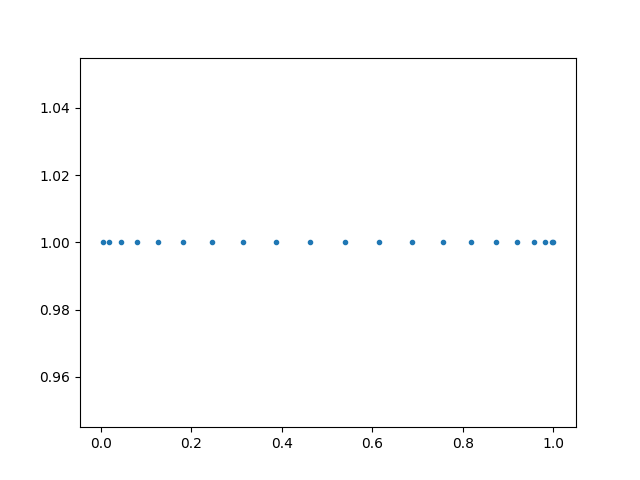

In [5]:
# Gaussian absiccae
a = np.array([0.34357004E-02,
  0.18014036E-01,
  0.43882786E-01,
  0.80441514E-01,
  0.12683405E+00,
  0.18197316E+00,
  0.24456650E+00,
  0.31314696E+00,
  0.38610707E+00,
  0.46173674E+00,
  0.53826326E+00,
  0.61389293E+00,
  0.68685304E+00,
  0.75543350E+00,
  0.81802684E+00,
  0.87316595E+00,
  0.91955849E+00,
  0.95611721E+00,
  0.98198596E+00,
  0.99656430E+00,
  0.10000000E+01])
fig = plt.figure()
plt.plot(a,np.ones_like(a), ".")
plt.show()

<IPython.core.display.Javascript object>


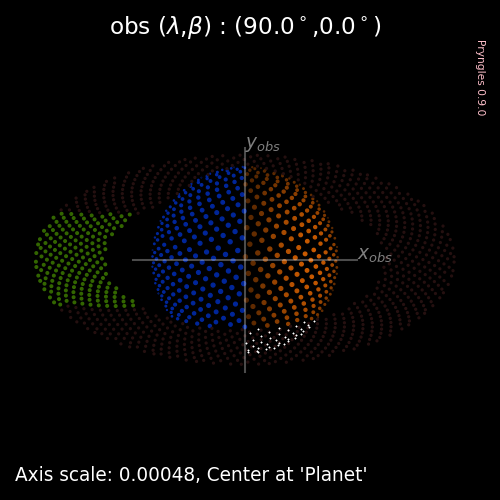

In [10]:
au = 1.496e+11
units=['au','msun','yr']
sys = System(units=units)
S=sys.add(radius=Consts.rsun/au, m = 1)
P=sys.add("Planet",primary=S,radius=Consts.rsaturn/au,a=3, m=2.8e-4)
R=sys.add("Ring",primary=P,
          fi=1.5, fe=2.25,
          i=30*Consts.deg,roll=90*Consts.deg,
          tau_gray_optical = 0.4)
sys.initialize_simulation()
sys.spangle_system()

incli = 0
azim = 90
sys.update_perspective(n_obs=Science.direction(azim,incli))
spangle_size_multi = 200
sys.sg.data.dsp *= spangle_size_multi

cond=(sys.sg.data.hidden_by_luz.apply(lambda x:'Ring' in x))&(sys.sg.data.visible)&\
     (~sys.sg.data.loc[sys.sg.data.name=="Planet","transit"])
cond1=(sys.sg.data.hidden_by_obs.apply(lambda x:'Ring' in x))&(sys.sg.data.illuminated)&\
      (~sys.sg.data.loc[sys.sg.data.name=="Planet","transit"])
cond += cond1

sys.sg.plot2d(include=["Planet", "Ring"],show_azim=False,highlight=(cond,dict()))
sys.sg.data.dsp /= spangle_size_multi

In [12]:
test = Scatterer(fname_planet="./data/fou_gasplanet.dat",fname_ring="./data/fou_ring_0_4_0_8.dat")

st = time.time()
out_dict = test.scattering(sys,normalize=True)
et = time.time()
print("Time total: ", et-st)

F = test.lambertian_test(np.arccos(test.phase_angle))/np.pi
print("Theoretical F: ",F)
# print(sys.data)
print("Phase angle: ", np.arccos(test.phase_angle)*180/np.pi)

Rings are present!
Time total:  0.5374047756195068
Theoretical F:  0.21220659078919377
Phase angle:  90.0


<IPython.core.display.Javascript object>


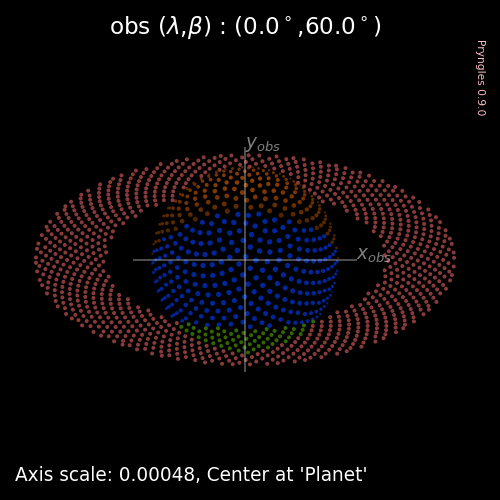

In [24]:
au = 1.496e+11
units=['au','msun','yr']
sys = System(units=units)
S=sys.add(radius=Consts.rsun/sys.ul, m = 1)
P=sys.add("Planet",primary=S, radius=Consts.rsaturn/sys.ul, 
          a=3, m=2.8e-4, nspangles=1000)
R=sys.add("Ring",primary=P,
          fi=1.5, fe=2.25,
          i=-30*Consts.deg,roll=0*Consts.deg,
          nspangles=1000,
          tau_gray_optical = 0.4)
sys.initialize_simulation()
sys.spangle_system()

azim = 0
incli = 60
sys.update_perspective(n_obs=Science.direction(azim,incli))
spangle_size_multi = 200
sys.sg.data.dsp *= spangle_size_multi
sys.sg.plot2d(include=["Planet","Ring"])
sys.sg.data.dsp /= spangle_size_multi

In [25]:
sys.sg.data.loc[sys.sg.data.name == "Ring", "tau_gray_optical"] = 0.4
sys.sg.data.loc[sys.sg.data.name == "Ring", "tau_gray_optical"]

1974    0.4
1975    0.4
1976    0.4
1977    0.4
1978    0.4
       ... 
3013    0.4
3014    0.4
3015    0.4
3016    0.4
3017    0.4
Name: tau_gray_optical, Length: 1044, dtype: float64

Geometry time:  2.7157068252563477
Rings are present!
Scattering time:  0.7163722515106201
True anomaly:  0.0 Phase angle:  120.00000000000001 
 F planet:  0.0003339141864083576 P planet:  0.15176835005234443 F ring:  0.0006863279032292066 P Ring:  0.04598250836631769


<IPython.core.display.Javascript object>


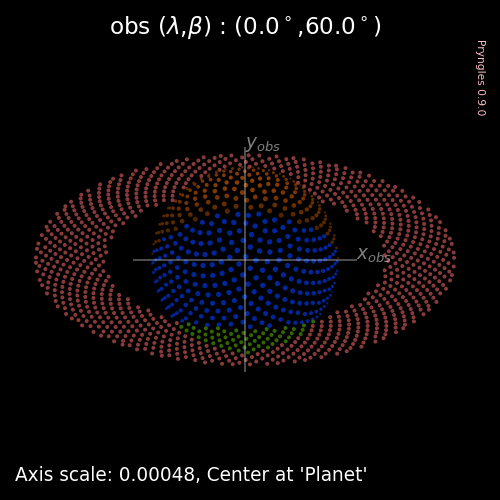

Geometry time:  2.6801769733428955
Rings are present!
Scattering time:  0.7795052528381348
True anomaly:  2.0000000000000004 Phase angle:  119.97986203936273 
 F planet:  0.000334102437662588 P planet:  0.1519068491390458 F ring:  0.000685050881376002 P Ring:  0.04601357002693916
Geometry time:  2.75130558013916
Rings are present!
Scattering time:  0.7177155017852783
True anomaly:  4.000000000000001 Phase angle:  119.91949710800908 
 F planet:  0.0003348204014900092 P planet:  0.15215234389282098 F ring:  0.0006841187281569008 P Ring:  0.046126639577224765
Geometry time:  2.7969577312469482
Rings are present!
Scattering time:  0.7172713279724121
True anomaly:  6.000000000000001 Phase angle:  119.81905158300643 
 F planet:  0.0003360572058009262 P planet:  0.15242451620720884 F ring:  0.0006813168677641544 P Ring:  0.04631225178755944
Geometry time:  2.7275547981262207
Rings are present!
Scattering time:  1.2277400493621826
True anomaly:  8.000000000000002 Phase angle:  119.678767855761

<IPython.core.display.Javascript object>


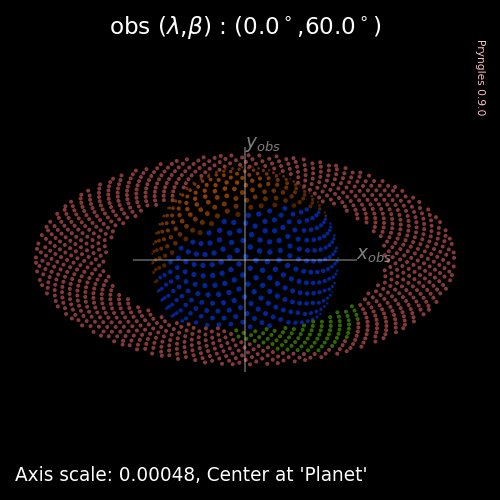

Geometry time:  2.6418211460113525
Rings are present!
Scattering time:  0.7060801982879639
True anomaly:  22.0 Phase angle:  117.62040192882647 
 F planet:  0.0003637317611783401 P planet:  0.15912126480775288 F ring:  0.0006069616086502081 P Ring:  0.050270034945865905
Geometry time:  2.7522192001342773
Rings are present!
Scattering time:  0.709043025970459
True anomaly:  24.000000000000004 Phase angle:  117.18054402075431 
 F planet:  0.00036946898090385805 P planet:  0.16038062968467334 F ring:  0.0005927217369359418 P Ring:  0.05106527436778166
Geometry time:  2.6951916217803955
Rings are present!
Scattering time:  0.707183837890625
True anomaly:  26.000000000000004 Phase angle:  116.70672904984612 
 F planet:  0.00037572169760590824 P planet:  0.16156488613477551 F ring:  0.0005760223318171933 P Ring:  0.0519209148161833
Geometry time:  2.7884018421173096
Rings are present!
Scattering time:  0.7013487815856934
True anomaly:  28.0 Phase angle:  116.19992265034135 
 F planet:  0.000

<IPython.core.display.Javascript object>


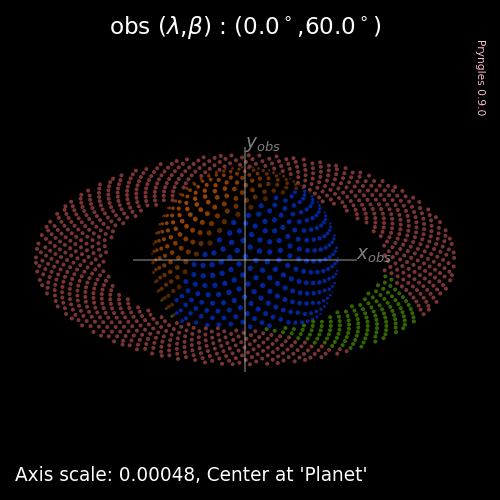

Geometry time:  2.749204397201538
Rings are present!
Scattering time:  0.692211389541626
True anomaly:  42.0 Phase angle:  111.81649205810683 
 F planet:  0.000442726151258208 P planet:  0.17414366765460898 F ring:  0.00044956804247274295 P Ring:  0.06058536837405476
Geometry time:  3.2957406044006348
Rings are present!
Scattering time:  0.7381420135498047
True anomaly:  44.0 Phase angle:  111.08407199856786 
 F planet:  0.00045294549421627663 P planet:  0.17572005373755803 F ring:  0.0004312331665211775 P Ring:  0.06185884520845205
Geometry time:  2.8522796630859375
Rings are present!
Scattering time:  0.6863887310028076
True anomaly:  46.00000000000001 Phase angle:  110.32846790991226 
 F planet:  0.00046375109505086484 P planet:  0.17728101665943968 F ring:  0.0004170915562152547 P Ring:  0.0631660955999594
Geometry time:  2.7819173336029053
Rings are present!
Scattering time:  0.6821296215057373
True anomaly:  48.00000000000001 Phase angle:  109.55080601228758 
 F planet:  0.000473

<IPython.core.display.Javascript object>


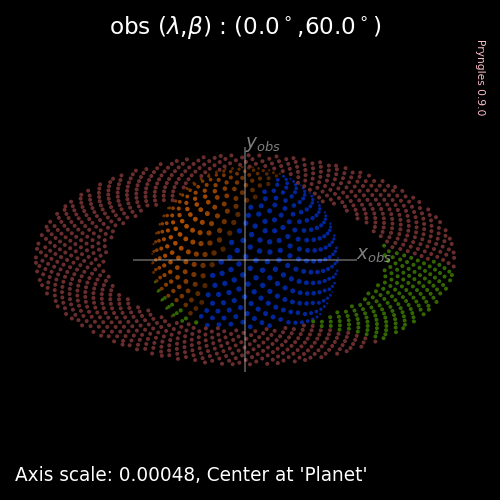

Geometry time:  2.8015048503875732
Rings are present!
Scattering time:  0.6647357940673828
True anomaly:  62.0 Phase angle:  103.5824805384173 
 F planet:  0.0005501802016262133 P planet:  0.18694470221326973 F ring:  0.0002854566710060298 P Ring:  0.07454212877743314
Geometry time:  2.771857738494873
Rings are present!
Scattering time:  0.6609477996826172
True anomaly:  64.00000000000001 Phase angle:  102.6678426193663 
 F planet:  0.0005661923058616798 P planet:  0.18774266972575726 F ring:  0.0002678626325888664 P Ring:  0.07602529858011182
Geometry time:  2.8056869506835938
Rings are present!
Scattering time:  0.6735095977783203
True anomaly:  66.00000000000001 Phase angle:  101.74083498456214 
 F planet:  0.0005801162350519566 P planet:  0.1879215247852053 F ring:  0.00025018263038448647 P Ring:  0.07751736200776439
Geometry time:  2.891895294189453
Rings are present!
Scattering time:  0.6622512340545654
True anomaly:  68.00000000000001 Phase angle:  100.80246831443904 
 F planet:

<IPython.core.display.Javascript object>


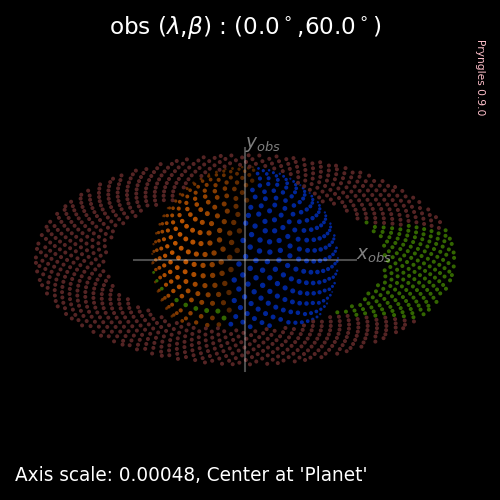

Geometry time:  2.700850009918213
Rings are present!
Scattering time:  0.6523933410644531
True anomaly:  82.0 Phase angle:  93.9981251303467 
 F planet:  0.000730093857686672 P planet:  0.18856340348468753 F ring:  8.566914201132515e-05 P Ring:  0.08914016291914513
Geometry time:  2.7251875400543213
Rings are present!
Scattering time:  0.6550898551940918
True anomaly:  84.0 Phase angle:  93.00382915404487 
 F planet:  0.0007538208993368382 P planet:  0.18820477972442404 F ring:  6.307218701074101e-05 P Ring:  0.09068858018842214
Geometry time:  2.7467703819274902
Rings are present!
Scattering time:  0.64923095703125
True anomaly:  86.0 Phase angle:  92.00676818146289 
 F planet:  0.000763409458038124 P planet:  0.18651624676281972 F ring:  4.078633188820929e-05 P Ring:  0.0922916217733778
Geometry time:  2.766125440597534
Rings are present!
Scattering time:  0.6589312553405762
True anomaly:  88.0 Phase angle:  91.00786043101726 
 F planet:  0.0007845416112465349 P planet:  0.1852178169

<IPython.core.display.Javascript object>


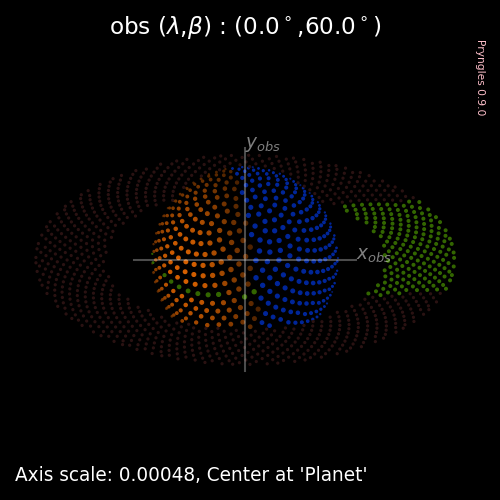

Geometry time:  2.8607113361358643
Rings are present!
Scattering time:  0.7765378952026367
True anomaly:  102.00000000000001 Phase angle:  84.04070540246006 
 F planet:  0.0008709097428850305 P planet:  0.17157525665660028 F ring:  9.083939492177058e-05 P Ring:  0.09263778605541591
Geometry time:  2.735690116882324
Rings are present!
Scattering time:  1.1276168823242188
True anomaly:  104.00000000000001 Phase angle:  83.06004368113106 
 F planet:  0.0008741108172885488 P planet:  0.16988622524997227 F ring:  0.00010312203486374078 P Ring:  0.09298195300700117
Geometry time:  2.9139323234558105
Rings are present!
Scattering time:  0.6572742462158203
True anomaly:  106.00000000000001 Phase angle:  82.08584204848957 
 F planet:  0.0008789283569286251 P planet:  0.16788918234396127 F ring:  0.00011438900992773995 P Ring:  0.09314050346378307
Geometry time:  2.958552598953247
Rings are present!
Scattering time:  0.7818074226379395
True anomaly:  108.00000000000001 Phase angle:  81.119052675

<IPython.core.display.Javascript object>


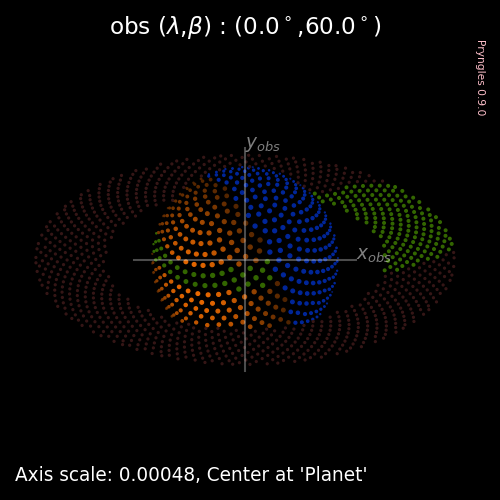

Geometry time:  2.873192548751831
Rings are present!
Scattering time:  0.6897249221801758
True anomaly:  122.0 Phase angle:  74.64142980628006 
 F planet:  0.0009582732784558345 P planet:  0.13765164154786533 F ring:  0.00016512178585704958 P Ring:  0.08844218579201396
Geometry time:  2.795840263366699
Rings are present!
Scattering time:  0.6749591827392578
True anomaly:  124.0 Phase angle:  73.76962224559674 
 F planet:  0.0009546250202934629 P planet:  0.13457964656595778 F ring:  0.00016934379972551134 P Ring:  0.08715834360408697
Geometry time:  2.766608238220215
Rings are present!
Scattering time:  0.6751694679260254
True anomaly:  126.00000000000001 Phase angle:  72.91434764917898 
 F planet:  0.0009682989708035239 P planet:  0.12943026689727144 F ring:  0.00017251387681749495 P Ring:  0.08591648620150111
Geometry time:  2.7615880966186523
Rings are present!
Scattering time:  0.6809446811676025
True anomaly:  128.00000000000003 Phase angle:  72.07668727829972 
 F planet:  0.00098

<IPython.core.display.Javascript object>


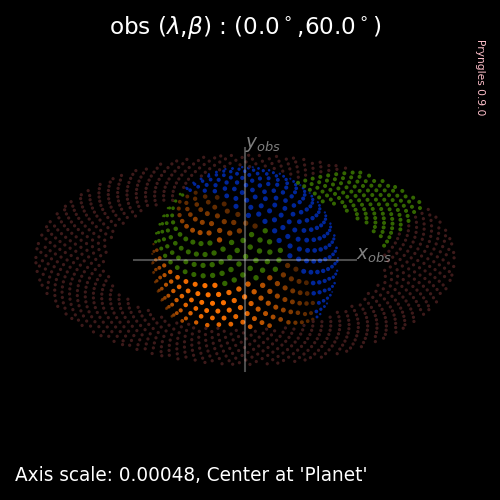

Geometry time:  2.679325580596924
Rings are present!
Scattering time:  0.712460994720459
True anomaly:  142.00000000000003 Phase angle:  66.79935268400142 
 F planet:  0.0010854523959454704 P planet:  0.1040099834989407 F ring:  0.00019197679862143573 P Ring:  0.07313076793895289
Geometry time:  2.792356491088867
Rings are present!
Scattering time:  0.7136218547821045
True anomaly:  144.00000000000003 Phase angle:  66.14270059672242 
 F planet:  0.0010942221561526916 P planet:  0.10318072206278593 F ring:  0.00019858535015174138 P Ring:  0.06945798789469194
Geometry time:  2.7117130756378174
Rings are present!
Scattering time:  0.7190408706665039
True anomaly:  146.00000000000003 Phase angle:  65.51374132416122 
 F planet:  0.0011101214396587213 P planet:  0.10301315409660015 F ring:  0.00020706682310445845 P Ring:  0.06575400220240532
Geometry time:  2.7390244007110596
Rings are present!
Scattering time:  0.7242569923400879
True anomaly:  148.00000000000003 Phase angle:  64.9135835899

<IPython.core.display.Javascript object>


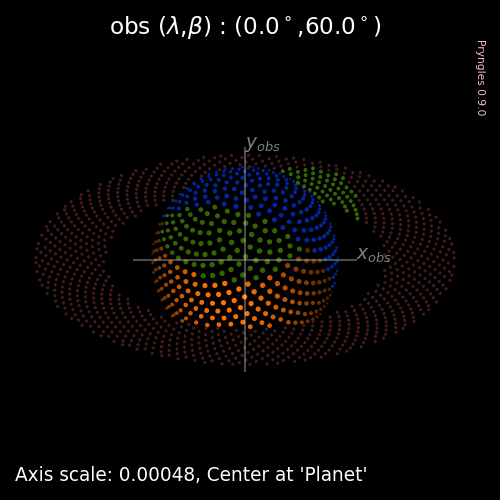

Geometry time:  2.6895840167999268
Rings are present!
Scattering time:  0.7476427555084229
True anomaly:  162.0 Phase angle:  61.60712063334549 
 F planet:  0.0012699852815582769 P planet:  0.10236373833034658 F ring:  0.00024806109449433407 P Ring:  0.04933476287380584
Geometry time:  2.775454044342041
Rings are present!
Scattering time:  0.7408151626586914
True anomaly:  164.0 Phase angle:  61.274083451433015 
 F planet:  0.001297026141691008 P planet:  0.1017034548619895 F ring:  0.00024832842590487124 P Ring:  0.04875966720937991
Geometry time:  2.810702085494995
Rings are present!
Scattering time:  0.7452661991119385
True anomaly:  166.0 Phase angle:  60.97837664232428 
 F planet:  0.0013164451857319006 P planet:  0.10150379303526973 F ring:  0.00024667394662492665 P Ring:  0.048332594381370414
Geometry time:  2.8799657821655273
Rings are present!
Scattering time:  0.7640509605407715
True anomaly:  168.0 Phase angle:  60.7206743698087 
 F planet:  0.0013293764635160855 P planet:  

<IPython.core.display.Javascript object>


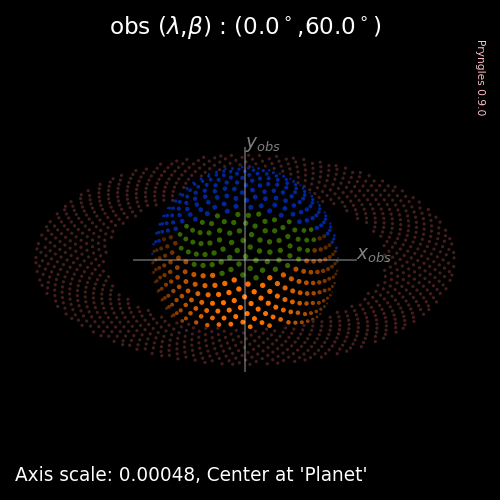

Geometry time:  3.1370997428894043
Rings are present!
Scattering time:  0.7811319828033447
True anomaly:  182.00000000000003 Phase angle:  60.02016051862137 
 F planet:  0.0013616048306747408 P planet:  0.10009022808947514 F ring:  0.00024477299138361103 P Ring:  0.04726581092040102
Geometry time:  2.828907012939453
Rings are present!
Scattering time:  0.7788281440734863
True anomaly:  184.00000000000003 Phase angle:  60.08059295930499 
 F planet:  0.0013628409291297206 P planet:  0.1000700003298452 F ring:  0.00024471552846240475 P Ring:  0.04732613195606989
Geometry time:  2.7966601848602295
Rings are present!
Scattering time:  0.7767553329467773
True anomaly:  186.00000000000003 Phase angle:  60.18115045347771 
 F planet:  0.0013574646550052732 P planet:  0.1001867509498427 F ring:  0.00024458545663457273 P Ring:  0.047425087815133354
Geometry time:  2.977428436279297
Rings are present!
Scattering time:  0.7767367362976074
True anomaly:  188.00000000000003 Phase angle:  60.321589798

<IPython.core.display.Javascript object>


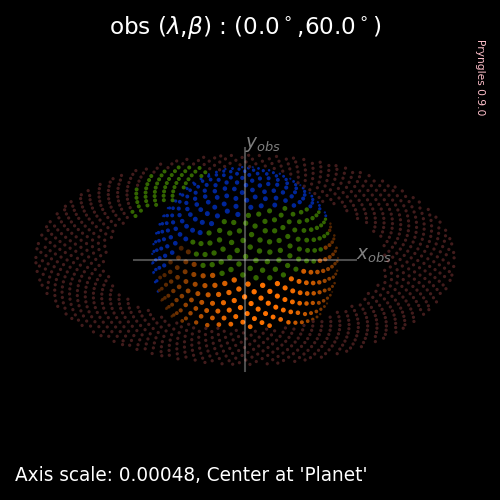

Geometry time:  2.996406316757202
Rings are present!
Scattering time:  0.740623950958252
True anomaly:  202.00000000000003 Phase angle:  62.38213889115944 
 F planet:  0.0012432022342029026 P planet:  0.10238142104127522 F ring:  0.00024613085049967465 P Ring:  0.05112090277457448
Geometry time:  2.727555513381958
Rings are present!
Scattering time:  0.749422550201416
True anomaly:  204.00000000000003 Phase angle:  62.82243944207901 
 F planet:  0.0012203123826891133 P planet:  0.10293216890236268 F ring:  0.00024316677963573578 P Ring:  0.052500619319332385
Geometry time:  2.77913498878479
Rings are present!
Scattering time:  0.7412412166595459
True anomaly:  206.00000000000003 Phase angle:  63.296722003527805 
 F planet:  0.0012005292114134643 P planet:  0.10382696852999139 F ring:  0.00023839870212501334 P Ring:  0.05429182177047749
Geometry time:  2.8089473247528076
Rings are present!
Scattering time:  0.9422664642333984
True anomaly:  208.00000000000003 Phase angle:  63.8040180566

<IPython.core.display.Javascript object>


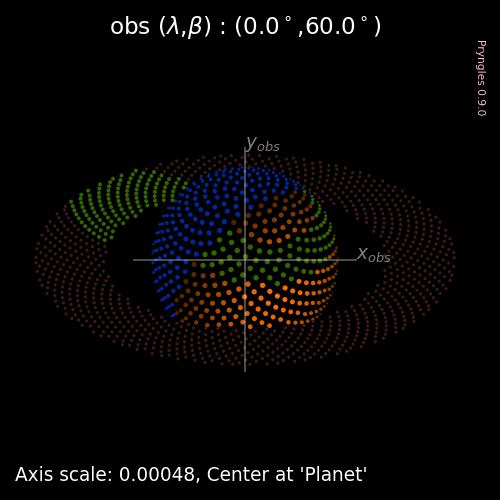

Geometry time:  2.895383834838867
Rings are present!
Scattering time:  0.7016580104827881
True anomaly:  222.00000000000003 Phase angle:  68.1912448152732 
 F planet:  0.0010436735318791034 P planet:  0.10622511690734493 F ring:  0.00018164704807379826 P Ring:  0.07900144294392149
Geometry time:  2.789720058441162
Rings are present!
Scattering time:  0.7011420726776123
True anomaly:  224.0 Phase angle:  68.92422468513877 
 F planet:  0.0010333829767881436 P planet:  0.10820456572428004 F ring:  0.0001793657676990023 P Ring:  0.08089101527873589
Geometry time:  2.8292200565338135
Rings are present!
Scattering time:  0.696662425994873
True anomaly:  226.0 Phase angle:  69.68038456917964 
 F planet:  0.0010182905227228715 P planet:  0.11024327270580356 F ring:  0.00017746663471894438 P Ring:  0.08220514736697572
Geometry time:  2.8015358448028564
Rings are present!
Scattering time:  0.7268819808959961
True anomaly:  228.0 Phase angle:  70.45859565682814 
 F planet:  0.0010136622173690794 

<IPython.core.display.Javascript object>


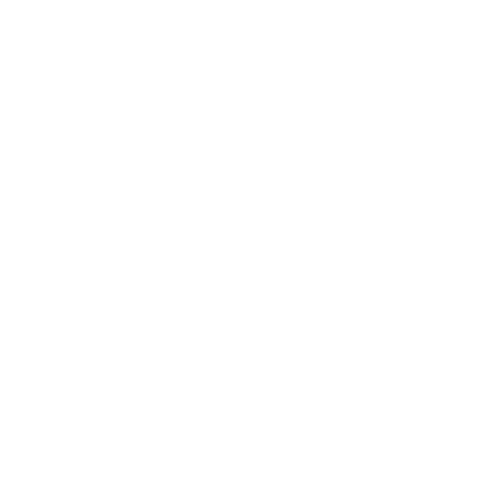

Geometry time:  2.805168628692627
Rings are present!
Scattering time:  0.6791543960571289
True anomaly:  242.0 Phase angle:  76.43038588375661 
 F planet:  0.0009446945481138029 P planet:  0.14755780188247622 F ring:  0.0001570746794741309 P Ring:  0.09069327651554891
Geometry time:  2.859614133834839
Rings are present!
Scattering time:  0.7046518325805664
True anomaly:  244.0 Phase angle:  77.34544025955961 
 F planet:  0.000929444799876087 P planet:  0.15133916533509167 F ring:  0.00015183116841349778 P Ring:  0.09151749090963254
Geometry time:  2.9641523361206055
Rings are present!
Scattering time:  0.6672368049621582
True anomaly:  246.0 Phase angle:  78.27283956128794 
 F planet:  0.0009225281989935945 P planet:  0.1541078568725303 F ring:  0.00014666642927024665 P Ring:  0.09213678338509132
Geometry time:  3.6514060497283936
Rings are present!
Scattering time:  0.6696469783782959
True anomaly:  248.0 Phase angle:  79.21157169156024 
 F planet:  0.0009238281878445568 P planet:  0.

<IPython.core.display.Javascript object>


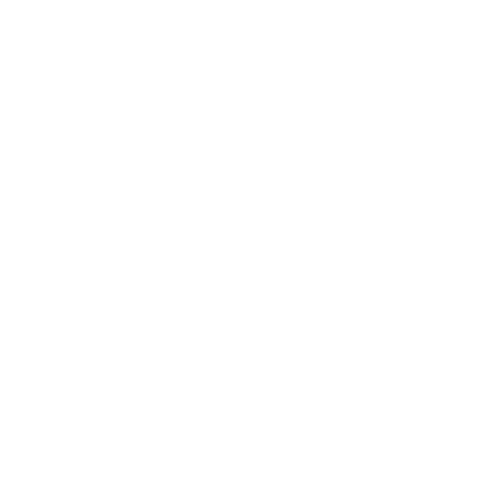

Geometry time:  2.827042818069458
Rings are present!
Scattering time:  0.6571817398071289
True anomaly:  262.00000000000006 Phase angle:  86.01764518014285 
 F planet:  0.0008674026731676741 P planet:  0.17581850529672746 F ring:  6.19142466589742e-05 P Ring:  0.0915533111005518
Geometry time:  2.8705389499664307
Rings are present!
Scattering time:  0.6562306880950928
True anomaly:  264.00000000000006 Phase angle:  87.0120600926168 
 F planet:  0.0008518707765625248 P planet:  0.17860280683555682 F ring:  4.594855953342516e-05 P Ring:  0.09086437394930753
Geometry time:  2.7816567420959473
Rings are present!
Scattering time:  0.6562614440917969
True anomaly:  266.00000000000006 Phase angle:  88.00920629179907 
 F planet:  0.0008461085555995873 P planet:  0.17998659754292823 F ring:  3.024396767620052e-05 P Ring:  0.09010092581353818
Geometry time:  2.8096280097961426
Rings are present!
Scattering time:  0.6569771766662598
True anomaly:  268.00000000000006 Phase angle:  89.0081652869753

<IPython.core.display.Javascript object>


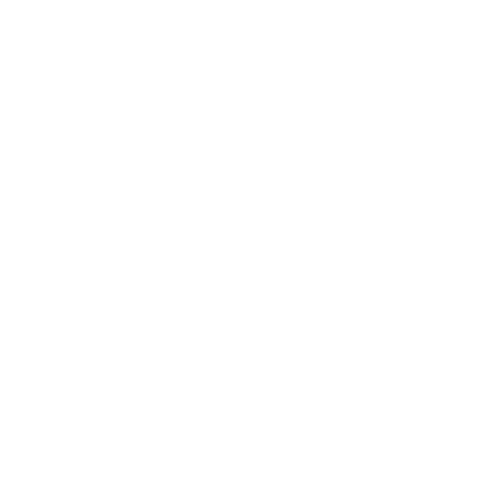

Geometry time:  2.9513511657714844
Rings are present!
Scattering time:  0.7603633403778076
True anomaly:  282.00000000000006 Phase angle:  95.97472754515414 
 F planet:  0.0006788647667833663 P planet:  0.18881566651630613 F ring:  0.00013087216140867752 P Ring:  0.0862023369814605
Geometry time:  3.7439382076263428
Rings are present!
Scattering time:  0.6607489585876465
True anomaly:  284.00000000000006 Phase angle:  96.9551719357044 
 F planet:  0.0006599904076445796 P planet:  0.189211832847742 F ring:  0.0001528938281574291 P Ring:  0.0847754079064508
Geometry time:  2.9227676391601562
Rings are present!
Scattering time:  0.6649367809295654
True anomaly:  286.00000000000006 Phase angle:  97.92912472180085 
 F planet:  0.0006404258999837961 P planet:  0.18872045789475989 F ring:  0.0001736131305669013 P Ring:  0.08335939681305483
Geometry time:  2.8325045108795166
Rings are present!
Scattering time:  0.6620702743530273
True anomaly:  288.00000000000006 Phase angle:  98.8956345621287

<IPython.core.display.Javascript object>


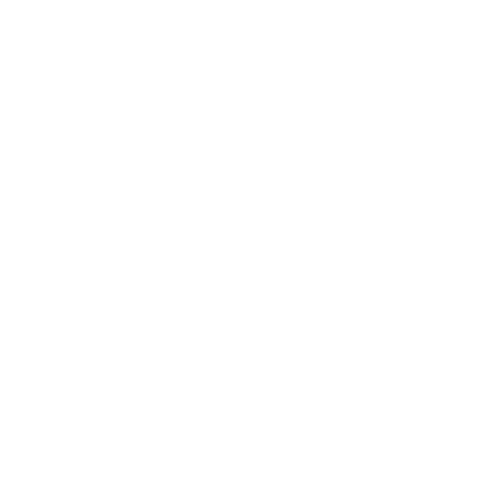

Geometry time:  2.810168981552124
Rings are present!
Scattering time:  0.6681430339813232
True anomaly:  302.00000000000006 Phase angle:  105.37053560710144 
 F planet:  0.0005302058836561009 P planet:  0.18562678090024914 F ring:  0.00031960101414969496 P Ring:  0.07158004046360633
Geometry time:  2.800269842147827
Rings are present!
Scattering time:  0.6685397624969482
True anomaly:  304.00000000000006 Phase angle:  106.24186205795371 
 F planet:  0.0005184110424274123 P planet:  0.1846253419755272 F ring:  0.00033460266864521546 P Ring:  0.07012120505646974
Geometry time:  2.7283785343170166
Rings are present!
Scattering time:  0.67116379737854
True anomaly:  306.00000000000006 Phase angle:  107.09663763941313 
 F planet:  0.0005073404751189382 P planet:  0.18341263871932592 F ring:  0.00035190701720900065 P Ring:  0.06868062507712566
Geometry time:  2.781428098678589
Rings are present!
Scattering time:  0.7091178894042969
True anomaly:  308.00000000000006 Phase angle:  107.93378311

<IPython.core.display.Javascript object>


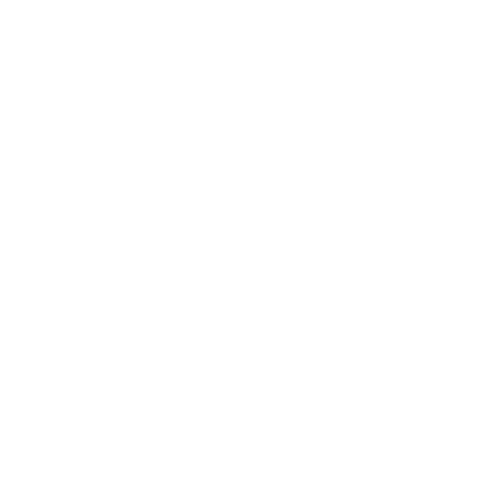

Geometry time:  2.6493284702301025
Rings are present!
Scattering time:  0.7454636096954346
True anomaly:  322.0 Phase angle:  113.20726335480579 
 F planet:  0.00042406539034659207 P planet:  0.17063664811029866 F ring:  0.00047986441199509113 P Ring:  0.05814098596932264
Geometry time:  2.7767155170440674
Rings are present!
Scattering time:  0.7446630001068115
True anomaly:  324.0 Phase angle:  113.86336003786516 
 F planet:  0.0004148486030312518 P planet:  0.16909694697575628 F ring:  0.0004963136567666 P Ring:  0.05698920796680405
Geometry time:  2.742781639099121
Rings are present!
Scattering time:  0.7112102508544922
True anomaly:  326.0 Phase angle:  114.49177110679179 
 F planet:  0.0004061898514753928 P planet:  0.16737255034093548 F ring:  0.0005137076659192627 P Ring:  0.055871967501632765
Geometry time:  3.062041759490967
Rings are present!
Scattering time:  0.6993710994720459
True anomaly:  328.0 Phase angle:  115.09139079372352 
 F planet:  0.00039786416550627714 P planet

<IPython.core.display.Javascript object>


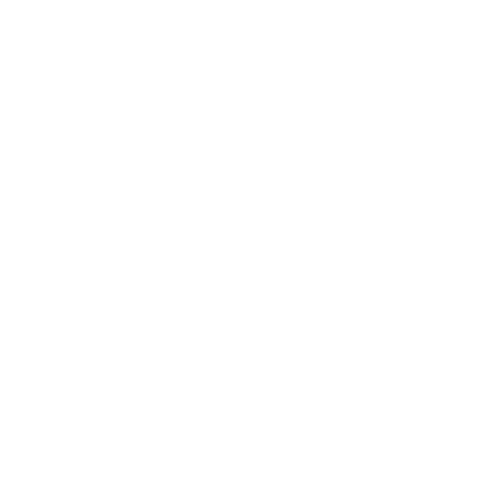

Geometry time:  2.708864688873291
Rings are present!
Scattering time:  0.710561990737915
True anomaly:  342.0 Phase angle:  118.39462081516454 
 F planet:  0.0003541154452299148 P planet:  0.15673193569559027 F ring:  0.0006320801214349778 P Ring:  0.04889265790589158
Geometry time:  2.8336918354034424
Rings are present!
Scattering time:  0.7123825550079346
True anomaly:  344.0 Phase angle:  118.72730648648296 
 F planet:  0.00034989192081217235 P planet:  0.15561847811147256 F ring:  0.000641487850389482 P Ring:  0.048291212773153395
Geometry time:  2.8004019260406494
Rings are present!
Scattering time:  0.724524736404419
True anomaly:  346.0 Phase angle:  119.02269711211504 
 F planet:  0.00034618149223194475 P planet:  0.15461616030929978 F ring:  0.000653719575241438 P Ring:  0.04775683156773732
Geometry time:  2.814521312713623
Rings are present!
Scattering time:  0.7170515060424805
True anomaly:  348.0 Phase angle:  119.28012069283811 
 F planet:  0.00034292919693633736 P planet:

<IPython.core.display.Javascript object>


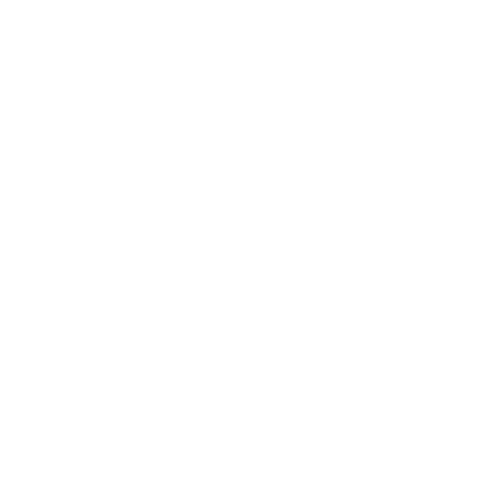

In [26]:
import time
test = Scatterer(fname_planet="./data/fou_gasplanet.dat",fname_ring="./data/fou_ring_0_4_0_8.dat")

# Translate years to degrees for a circular orbit
test.update_data(sys)
n = test.orbital_rotation_rate()
nu0 = 0*Consts.deg
nu = 360*Consts.deg
nstep = 181
step = ((nu-nu0)/nstep)/n
steps = np.linspace(nu0*step,nstep*step,nstep)

# Save arrays
Fp = []
Pp = []
Fr = []
Pr = []
P = []
alpha = []
make_plot = False

for step in steps:
    st = time.time()
    sys.integrate(step)
    sys.update_perspective()
    et = time.time()
    print("Geometry time: ",et-st)
    
    st = time.time()
    out_dict = test.scattering(sys)
    et = time.time()
    print("Scattering time: ",et-st)
    
    print("True anomaly: ",step*Consts.rad*n,"Phase angle: ",np.arccos(test.phase_angle)*Consts.rad,
          "\n F planet: ", out_dict["Stotp"][0],"P planet: ", out_dict["Ptotp"],
          "F ring: ", out_dict["Stotr"][0], "P Ring: ", out_dict["Ptotr"])
    Fp += [out_dict["Stotp"][0]]
    Pp += [out_dict["Ptotp"]]
    Fr += [out_dict["Stotr"][0]]
    Pr += [out_dict["Ptotr"]]
    P += [out_dict["Ptot"]]
    alpha += [np.arccos(test.phase_angle)*Consts.rad]
    
#     if step*Consts.rad*n%20 < 1:
#         sys.sg.data.dsp *= spangle_size_multi
#         sys.sg.plot2d(include=["Planet","Ring"])
#         sys.sg.data.dsp /= spangle_size_multi

Fp = np.array(Fp)
Pp = np.array(Pp)
Fr = np.array(Fr)
Pr = np.array(Pr)
P = np.array(P)

<IPython.core.display.Javascript object>


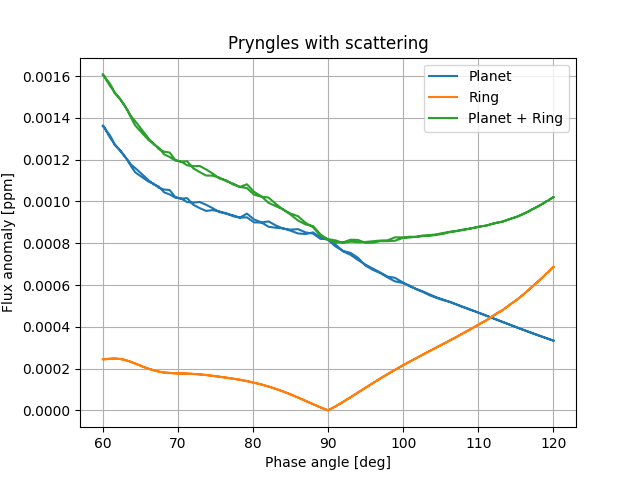

<IPython.core.display.Javascript object>


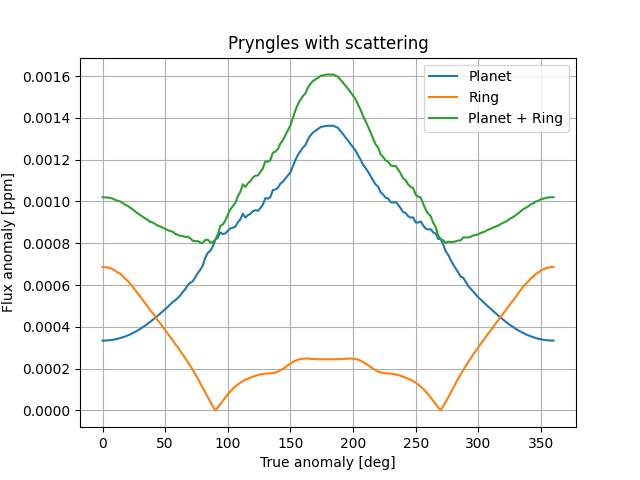

<IPython.core.display.Javascript object>


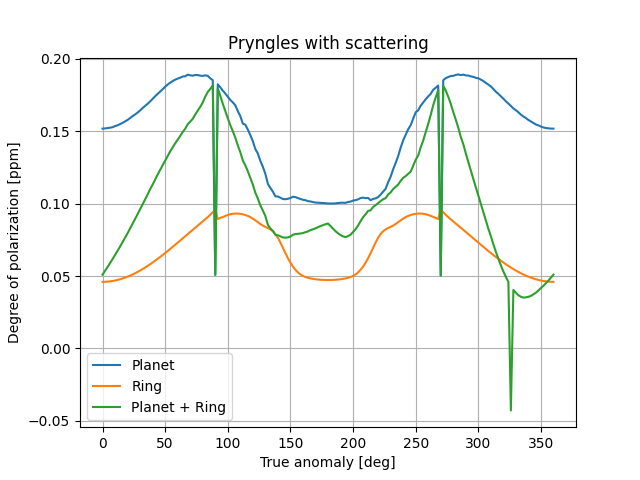

In [27]:
import matplotlib.pyplot as plt
n = test.orbital_rotation_rate()
nu0 = 0*Consts.deg
nu = 360*Consts.deg
nstep = 181
step = ((nu-nu0)/nstep)/n
steps = np.linspace(nu0*step,nstep*step,nstep)
steps = steps*Consts.rad*n

fig=plt.figure()
ax=fig.gca()
ax.plot(alpha,Fp,label="Planet")
ax.plot(alpha,Fr,label="Ring")
ax.plot(alpha,Fp+Fr,label="Planet + Ring")
ax.set_xlabel("Phase angle [deg]")
ax.set_ylabel("Flux anomaly [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
plt.show()

fig=plt.figure()
ax=fig.gca()
ax.plot(steps,Fp,label="Planet")
ax.plot(steps,Fr,label="Ring")
ax.plot(steps,Fp+Fr,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Flux anomaly [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
plt.show()

fig=plt.figure()
ax=fig.gca()
ax.plot(steps,Pp,label="Planet")
ax.plot(steps,Pr,label="Ring")
ax.plot(steps,P,label="Planet + Ring")
ax.set_xlabel("True anomaly [deg]")
ax.set_ylabel("Degree of polarization [ppm]")
ax.set_title("Pryngles with scattering")
ax.legend();
ax.grid()
plt.show()

# Re-check

In [ ]:
print(sys.sg.data[sys.sg.data.name=="Planet"].azim_obs - sys.sg.data[sys.sg.data.name=="Planet"].azim_luz)
print(test.data[test.data.name=="Planet"].azim_obs_luz)